In [1]:
!pip install aws-fortuna

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor

from fortuna.conformal import EnbPI
from fortuna.metric.regression import prediction_interval_coverage_probability

In [3]:
from sklearn.datasets import fetch_openml

bike_sharing = fetch_openml(
    "Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas"
)
df = bike_sharing.frame

In [4]:
df.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0,16
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0,40
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0,32
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0,13
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0,1


In [5]:
df.shape

(17379, 13)

In [6]:
df.groupby(["weekday", "hour"])["count"].mean()

weekday  hour
0        0        93.990385
         1        77.432692
         2        61.627451
         3        31.144231
         4         9.362745
                    ...    
6        19      239.932692
         20      180.865385
         21      156.000000
         22      139.663462
         23      115.855769
Name: count, Length: 168, dtype: float64

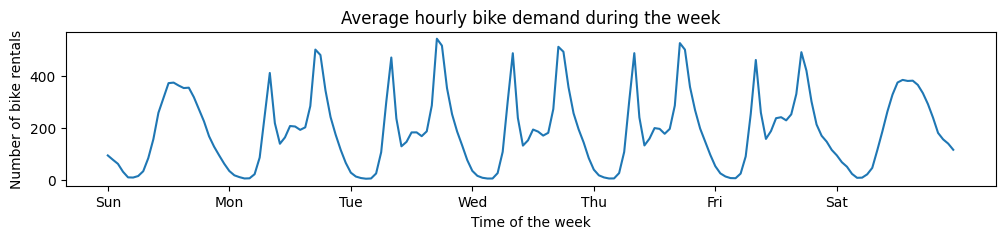

In [7]:
fig, ax = plt.subplots(figsize=(12, 2))
average_week_demand = df.groupby(["weekday", "hour"])["count"].mean()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)

In [8]:
df = df.sample(500)
y = df["count"] / df["count"].max()
X = df.drop("count", axis="columns")
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)

In [9]:
y.shape

(500,)

## Data bootstrapping

EnbPI requires bootstrapping the data, i.e. sampling with replacement random subsets of the time series and training a model for each of these samples.

In [10]:
class DataFrameBootstrapper:
    def __init__(self, n_samples: int):
        self.n_samples = n_samples

    def __call__(
        self, X: np.ndarray, y: np.ndarray
    ) -> tuple[np.ndarray, list[tuple[np.ndarray, np.ndarray]]]:
        indices = np.random.choice(y.shape[0], size=(self.n_samples, y.shape[0]))
        return indices, [(X.iloc[idx], y.iloc[idx]) for idx in indices]

In [11]:
n_bs_samples = 10
bs_indices, bs_train_data = DataFrameBootstrapper(n_samples=n_bs_samples)(
    X_train, y_train
)

In [12]:
# returns 10 boostrap samples from the training set
bs_indices.shape

(10, 400)

In [13]:
bs_indices

array([[376,  53, 126, ..., 201, 396, 321],
       [321,  47, 146, ..., 252,  45, 102],
       [244, 258,  84, ..., 326,  75,  47],
       ...,
       [ 40, 273, 201, ..., 334, 333,  61],
       [196, 239, 262, ..., 167, 168,  47],
       [ 24, 235, 317, ..., 249, 303, 214]])

In [14]:
X_train.shape

(400, 12)

In [15]:
len(bs_train_data)

10

In [16]:
# first bootstrap sample - X
bs_train_data[0][0]

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
16864,winter,1,12,11,False,1,True,rain,18.86,22.725,0.94,15.0013
14012,fall,1,8,1,False,0,False,clear,25.42,29.545,0.78,8.9981
11443,summer,1,4,0,False,5,True,clear,22.14,25.760,0.68,36.9974
6325,winter,0,9,3,False,1,True,misty,25.42,27.275,0.94,0.0000
8490,spring,0,12,11,False,0,False,clear,12.30,15.150,0.70,11.0014
...,...,...,...,...,...,...,...,...,...,...,...,...
11931,summer,1,5,8,False,4,True,clear,21.32,25.000,0.55,30.0026
4606,fall,0,7,20,False,5,True,clear,28.70,32.575,0.51,15.0013
10823,summer,1,4,2,False,0,False,misty,14.76,17.425,0.76,11.0014
15921,winter,1,11,2,False,4,True,clear,13.12,16.665,0.66,8.9981


In [17]:
# first bootstrap sample - y
bs_train_data[0][1]

16864    0.150901
14012    0.127252
11443    0.082207
6325     0.005631
8490     0.095721
           ...   
11931    0.713964
4606     0.386261
10823    0.091216
15921    0.022523
15264    0.038288
Name: count, Length: 400, dtype: float64

In [18]:
# Get a boolean series where True indicates the index is duplicated
duplicate_indices = bs_train_data[0][0].index.duplicated(keep=False)

# Print the duplicated indices
print(bs_train_data[0][0].index[duplicate_indices])

Int64Index([ 8490, 15992,  6257, 13288, 13755, 11931, 10703,  3047, 17219,
            10120,
            ...
             8592, 15881, 15642, 11398, 14076, 15668,  3345, 11931,  4606,
            15264],
           dtype='int64', length=237)


In [19]:
bs_train_data[0][0].loc[bs_train_data[0][0].index[duplicate_indices][0]]

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
8490,spring,0,12,11,False,0,False,clear,12.3,15.15,0.7,11.0014
8490,spring,0,12,11,False,0,False,clear,12.3,15.15,0.7,11.0014


## Model Definition

In [20]:
categorical_columns = ["weather", "season", "holiday", "workingday"]
categories = [
    ["clear", "misty", "rain", "heavy_rain"],
    ["spring", "summer", "fall", "winter"],
    ["False", "True"],
    ["False", "True"],
]
ordinal_encoder = OrdinalEncoder(categories=categories)

gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, categorical_columns),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    ),
    HistGradientBoostingRegressor(
        categorical_features=categorical_columns,
    ),
).set_output(transform="pandas")

## Model training for each bootstrap sample

In [21]:
bs_train_preds = np.zeros((n_bs_samples, X_train.shape[0]))
bs_test_preds = np.zeros((n_bs_samples, X_test.shape[0]))
for i, batch in enumerate(bs_train_data):
    gbrt_pipeline.fit(*batch)
    bs_train_preds[i] = gbrt_pipeline.predict(X_train)
    bs_test_preds[i] = gbrt_pipeline.predict(X_test)

In [22]:
conformal_intervals = EnbPI().conformal_interval(
    bootstrap_indices=bs_indices,
    bootstrap_train_preds=bs_train_preds,
    bootstrap_test_preds=bs_test_preds,
    train_targets=y_train.values,
    error=0.05,
)

In [23]:
# In order to evaluate conditional coverage, we measure the Prediction Interval Coverage Probability (PICP), i.e. the percentage of
# test target variables that actually falls within the conformal intervals. We further measure the percentage of intervals that contain the point
# predictions given by the model. Finally, we measure the size of the conformal intervals, which EnbPI takes to be the same for every intervals
# if no online feedback is provided, like in this case.

In [24]:
print(
    "Percentage of intervals containing average bootstrap predictions: "
    f"{prediction_interval_coverage_probability(*conformal_intervals.T, bs_test_preds.mean(0))}."
)
print(
    "Percentage of intervals containing true targets: "
    f"{prediction_interval_coverage_probability(*conformal_intervals.T, y_test.values)}."
)
print(f"Size of the conformal intervals: {np.diff(conformal_intervals)[0][0]}")

Percentage of intervals containing average bootstrap predictions: 1.0.
Percentage of intervals containing true targets: 0.949999988079071.
Size of the conformal intervals: 0.444624125957489


In the example above, EnbPI assumes that all the predictions in the test dataset are done at once, without any online feedback from incoming observations of the test targets. As a consequence, the size of the conformal intervals is the same for all test data points.

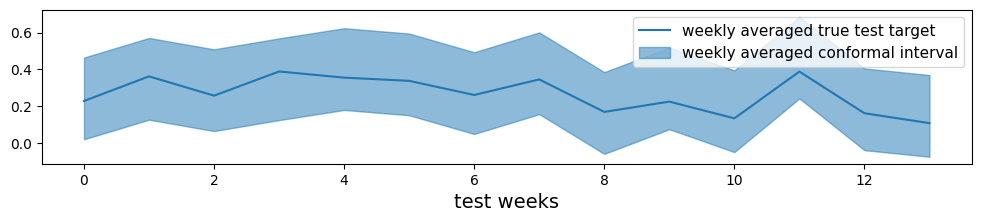

In [25]:
def weakly_avg(x):
    s = x.shape[0] // 7
    x = x[: s * 7]
    return x.reshape(7, s, *x.shape[1:]).mean(0)


weekly_avg_test = weakly_avg(y_test.values)
n_weeks = weekly_avg_test.shape[0]

plt.figure(figsize=(12, 2))
plt.plot(weakly_avg(y_test.values), label="weekly averaged true test target")
plt.fill_between(
    np.arange(n_weeks),
    *weakly_avg(conformal_intervals).T,
    alpha=0.5,
    color="C0",
    label="weekly averaged conformal interval",
)
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")

## EnbPI with online feedback

In [26]:
batch_size = 1
conformal_intervals2 = np.zeros((len(y_test), 2))
for i in range(0, len(y_test), batch_size):
    if i == 0:
        conformal_intervals2[:batch_size], train_residuals = EnbPI().conformal_interval(
            bootstrap_indices=bs_indices,
            bootstrap_train_preds=bs_train_preds,
            bootstrap_test_preds=bs_test_preds[:, :batch_size],
            train_targets=y_train.values,
            error=0.05,
            return_residuals=True,
        )
    else:
        (
            conformal_intervals2[i : i + batch_size],
            train_residuals,
        ) = EnbPI().conformal_interval_from_residuals(
            train_residuals=train_residuals,
            bootstrap_new_train_preds=bs_test_preds[:, i - batch_size : i],
            bootstrap_new_test_preds=bs_test_preds[:, i : i + batch_size],
            new_train_targets=y_test.values[i - batch_size : i],
            error=0.05,
        )

Similarly as done above, we compute the percentage of predictions and true test targets falling within the conformal intervals. Again, it is good to see that all conformal intervals include the point predictions. Also, the percentage of intervals containing the true targets increased to around 83%, getting closer to the desired coverage of 95%.

In [27]:
print(
    "Percentage of intervals containing average bootstrap predictions: "
    f"{prediction_interval_coverage_probability(*conformal_intervals2.T, bs_test_preds.mean(0))}."
)
print(
    "Percentage of intervals containing true targets: "
    f"{prediction_interval_coverage_probability(*conformal_intervals2.T, y_test.values)}."
)

Percentage of intervals containing average bootstrap predictions: 1.0.
Percentage of intervals containing true targets: 0.9300000071525574.


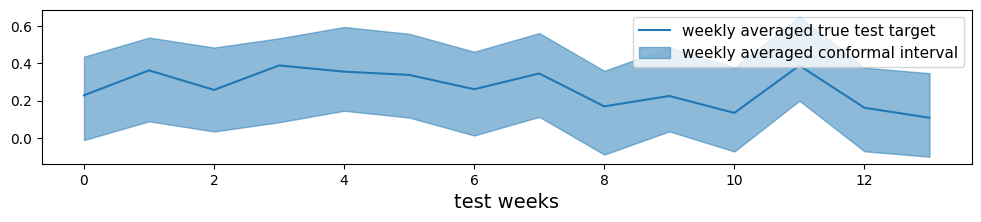

In [28]:
plt.figure(figsize=(12, 2))
plt.plot(weakly_avg(y_test.values), label="weekly averaged true test target")
plt.fill_between(
    np.arange(n_weeks),
    *weakly_avg(conformal_intervals2).T,
    alpha=0.5,
    color="C0",
    label="weekly averaged conformal interval",
)
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")

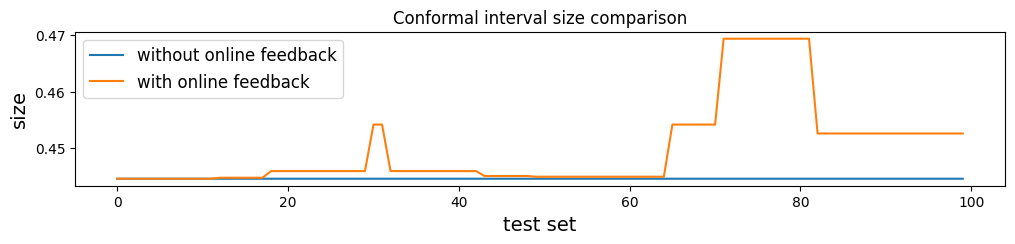

In [29]:
# The following plot compares the size of the intervals without and with online feedback.
plt.figure(figsize=(12, 2))
plt.title("Conformal interval size comparison")
plt.plot(np.diff(conformal_intervals), label="without online feedback")
plt.plot(np.diff(conformal_intervals2), label="with online feedback")
plt.xlabel("test set", fontsize=14)
plt.ylabel("size", fontsize=14)
plt.legend(fontsize=12)

We should remark again that the feedback on the conformal intervals was provided without having to retrain the model, which is useful in practice. However, if the distribution of the data starts drifting over time, the conformal intervals may progressively become large and unusable. In such case, one may track the conformal interval size and trigger retraining after it reaches a certain threshold.